In [8]:
import torch
from diffusers import DDIMScheduler, AutoencoderKL, KandinskyV22PriorPipeline, StableDiffusionPipeline
from PIL import Image


In [9]:
# base_model_path = "runwayml/stable-diffusion-v1-5"
# vae_model_path = "stabilityai/sd-vae-ft-mse"
# image_encoder_path = "sdxl_models/image_encoder/"
# prior_model_path = "kandinsky-community/kandinsky-2-2-prior"
# ip_ckpt = "models/ip-adapter_sd15_vit-G.bin"
# device = "cuda"

base_model_path = "/data/pretrained_models/stable-diffusion-v1-5"
vae_model_path = "/data/pretrained_models/sd-vae-ft-mse"
image_encoder_path = "/data/pretrained_models/IP-Adapter/sdxl_models/image_encoder/"
prior_model_path = "/data/pretrained_models/kandinsky-2-2-prior"
ip_ckpt = "/data/pretrained_models/IP-Adapter/models/ip-adapter_sd15_vit-G.bin"
device = "cuda:1"
dtype = torch.float16

num_train_timesteps=1000

In [10]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=num_train_timesteps,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    # beta_schedule="linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=dtype, device=device)

In [22]:
# load Prior pipeline
# pipe_prior = KandinskyV22PriorPipeline.from_pretrained(prior_model_path, torch_dtype=dtype).to(device)

# # generate clip image embeds
# prompt = [
#     "a photograph of an astronaut riding a horse",
#     "a macro wildlife photo of a green frog in a rainforest pond, highly detailed, eye-level shot",
#     "kid's coloring book, a happy young girl holding a flower, cartoon, thick lines, black and white, white background",
#     "a professional photograph of a woman with red and very short hair",
# ]
# clip_image_embeds = pipe_prior(prompt, generator=torch.manual_seed(42)).image_embeds

image = Image.open("/home/ccy/code/IP-Adapter/assets/images/river.png").convert("RGB")
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
image_encoder = CLIPVisionModelWithProjection.from_pretrained(image_encoder_path).to(device, dtype=dtype)
clip_image_processor = CLIPImageProcessor()
clip_image_embeds = image_encoder(clip_image_processor(images=image, return_tensors="pt").pixel_values.to(device, dtype=dtype)).image_embeds
# repeat 4 times
clip_image_embeds = clip_image_embeds.repeat(4, 1, 1)

In [23]:
# # load SD pipeline
# pipe = StableDiffusionPipeline.from_pretrained(
#     base_model_path,
#     torch_dtype=dtype,
#     scheduler=noise_scheduler,
#     vae=vae,
#     feature_extractor=None,
#     safety_checker=None
# )

# # load ip-adapter
# ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

# images = ip_model.generate(clip_image_embeds=clip_image_embeds, num_samples=1, width=512, height=512, num_inference_steps=50, seed=42)
# # image_grid(images, 1, 4)

/tmp/ipykernel_4055804/782883703.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")


Debug: num_prompts=4, num_samples=1, batch_size=4
Debug: latent shape will be (4, 4, 64, 64)
Debug: latents shape: torch.Size([4, 4, 64, 64])
Debug: prompt_embeds shape: torch.Size([4, 81, 768])
Debug: negative_prompt_embeds shape: torch.Size([4, 81, 768])
Debug: image_prompt_embeds shape: torch.Size([4, 4, 768])
Debug: uncond_image_prompt_embeds shape: torch.Size([4, 4, 768])
time steps: tensor([9.8096e-01, 9.6094e-01, 9.4092e-01, 9.2090e-01, 9.0088e-01, 8.8086e-01,
        8.6084e-01, 8.4082e-01, 8.2129e-01, 8.0078e-01, 7.8125e-01, 7.6074e-01,
        7.4121e-01, 7.2070e-01, 7.0117e-01, 6.8066e-01, 6.6113e-01, 6.4111e-01,
        6.2109e-01, 6.0107e-01, 5.8105e-01, 5.6104e-01, 5.4102e-01, 5.2100e-01,
        5.0098e-01, 4.8096e-01, 4.6094e-01, 4.4092e-01, 4.2090e-01, 4.0088e-01,
        3.8086e-01, 3.6084e-01, 3.4082e-01, 3.2080e-01, 3.0078e-01, 2.8076e-01,
        2.6123e-01, 2.4121e-01, 2.2119e-01, 2.0117e-01, 1.8115e-01, 1.6113e-01,
        1.4111e-01, 1.2109e-01, 1.0107e-01, 8.10

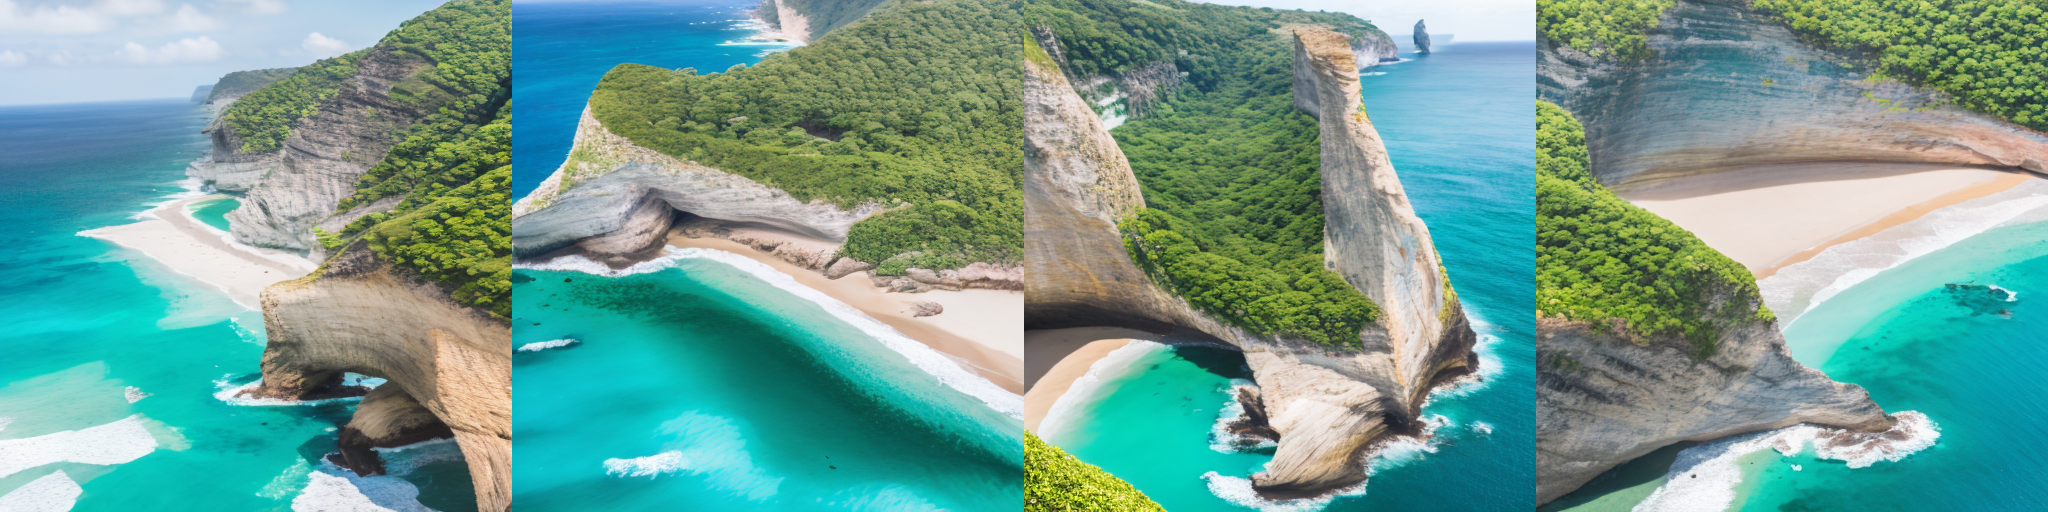

In [25]:
import torch
import os
from typing import List
from diffusers.pipelines.controlnet import MultiControlNetModel
from diffusers import UNet2DConditionModel
from PIL import Image
from safetensors import safe_open
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from methodes import METHODES


from ip_adapter.utils import is_torch2_available, get_generator

if is_torch2_available():
    from ip_adapter.attention_processor import (
        AttnProcessor2_0 as AttnProcessor,
    )
    from ip_adapter.attention_processor import (
        CNAttnProcessor2_0 as CNAttnProcessor,
    )
    from ip_adapter.attention_processor import (
        IPAttnProcessor2_0 as IPAttnProcessor,
    )
else:
    from ip_adapter.attention_processor import AttnProcessor, CNAttnProcessor, IPAttnProcessor
from ip_adapter.resampler import Resampler


class ImageProjModel(torch.nn.Module):
    """Projection Model"""

    def __init__(self, cross_attention_dim=1024, clip_embeddings_dim=1024, clip_extra_context_tokens=4):
        super().__init__()

        self.generator = None
        self.cross_attention_dim = cross_attention_dim
        self.clip_extra_context_tokens = clip_extra_context_tokens
        self.proj = torch.nn.Linear(clip_embeddings_dim, self.clip_extra_context_tokens * cross_attention_dim)
        self.norm = torch.nn.LayerNorm(cross_attention_dim)

    def forward(self, image_embeds):
        embeds = image_embeds
        clip_extra_context_tokens = self.proj(embeds).reshape(
            -1, self.clip_extra_context_tokens, self.cross_attention_dim
        )
        clip_extra_context_tokens = self.norm(clip_extra_context_tokens)
        return clip_extra_context_tokens


class MLPProjModel(torch.nn.Module):
    """SD model with image prompt"""
    def __init__(self, cross_attention_dim=1024, clip_embeddings_dim=1024):
        super().__init__()
        
        self.proj = torch.nn.Sequential(
            torch.nn.Linear(clip_embeddings_dim, clip_embeddings_dim),
            torch.nn.GELU(),
            torch.nn.Linear(clip_embeddings_dim, cross_attention_dim),
            torch.nn.LayerNorm(cross_attention_dim)
        )
        
    def forward(self, image_embeds):
        clip_extra_context_tokens = self.proj(image_embeds)
        return clip_extra_context_tokens


class IPAdapter:
    def __init__(self, base_model_path, image_encoder_path, vae, ip_ckpt, device, num_tokens=4):
        self.device = device
        self.image_encoder_path = image_encoder_path
        self.base_model_path = base_model_path
        self.ip_ckpt = ip_ckpt
        self.num_tokens = num_tokens

        self.unet = UNet2DConditionModel.from_pretrained(self.base_model_path, subfolder="unet").to(
            self.device, dtype=dtype
        )
        self.vae = vae
        self.set_ip_adapter()

        # load image encoder
        self.image_encoder = CLIPVisionModelWithProjection.from_pretrained(self.image_encoder_path).to(
            self.device, dtype=dtype
        )

        # 添加文本编码器
        from transformers import CLIPTextModel, CLIPTokenizer
        self.tokenizer = CLIPTokenizer.from_pretrained(self.base_model_path, subfolder="tokenizer")
        self.text_encoder = CLIPTextModel.from_pretrained(self.base_model_path, subfolder="text_encoder").to(
            self.device, dtype=dtype
        )

        self.clip_image_processor = CLIPImageProcessor()
        # image proj model
        self.image_proj_model = self.init_proj()

        self.load_ip_adapter()

    def init_proj(self):
        image_proj_model = ImageProjModel(
            cross_attention_dim=self.unet.config.cross_attention_dim,
            clip_embeddings_dim=self.image_encoder.config.projection_dim,
            clip_extra_context_tokens=self.num_tokens,
        ).to(self.device, dtype=dtype)
        return image_proj_model
    
    # 添加 encode_prompt 方法
    def encode_prompt(self, prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt):
        batch_size = len(prompt) if isinstance(prompt, list) else 1
        
        # 编码正面提示词
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        
        if text_input_ids.shape[-1] > self.tokenizer.model_max_length:
            text_input_ids = text_input_ids[:, :self.tokenizer.model_max_length]
        
        prompt_embeds = self.text_encoder(text_input_ids.to(device))[0]
        
        # 重复以匹配 num_images_per_prompt
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, -1, prompt_embeds.shape[-1])
        
        # 编码负面提示词
        if do_classifier_free_guidance:
            uncond_tokens = negative_prompt if negative_prompt is not None else [""]
            if isinstance(uncond_tokens, str):
                uncond_tokens = [uncond_tokens]
            
            max_length = text_input_ids.shape[-1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )
            
            negative_prompt_embeds = self.text_encoder(uncond_input.input_ids.to(device))[0]
            
            # 重复以匹配 num_images_per_prompt
            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, -1, negative_prompt_embeds.shape[-1])
        else:
            negative_prompt_embeds = None
        
        return prompt_embeds, negative_prompt_embeds

    def set_ip_adapter(self):
        unet = self.unet
        attn_procs = {}
        for name in unet.attn_processors.keys():
            cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
            if name.startswith("mid_block"):
                hidden_size = unet.config.block_out_channels[-1]
            elif name.startswith("up_blocks"):
                block_id = int(name[len("up_blocks.")])
                hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
            elif name.startswith("down_blocks"):
                block_id = int(name[len("down_blocks.")])
                hidden_size = unet.config.block_out_channels[block_id]
            if cross_attention_dim is None:
                attn_procs[name] = AttnProcessor()
            else:
                attn_procs[name] = IPAttnProcessor(
                    hidden_size=hidden_size,
                    cross_attention_dim=cross_attention_dim,
                    scale=1.0,
                    num_tokens=self.num_tokens,
                ).to(self.device, dtype=dtype)
        unet.set_attn_processor(attn_procs)
        if hasattr(self, "controlnet"):
            if isinstance(self.controlnet, MultiControlNetModel):
                for controlnet in self.controlnet.nets:
                    controlnet.set_attn_processor(CNAttnProcessor(num_tokens=self.num_tokens))
            else:
                self.controlnet.set_attn_processor(CNAttnProcessor(num_tokens=self.num_tokens))

    def load_ip_adapter(self):
        if os.path.splitext(self.ip_ckpt)[-1] == ".safetensors":
            state_dict = {"image_proj": {}, "ip_adapter": {}}
            with safe_open(self.ip_ckpt, framework="pt", device="cpu") as f:
                for key in f.keys():
                    if key.startswith("image_proj."):
                        state_dict["image_proj"][key.replace("image_proj.", "")] = f.get_tensor(key)
                    elif key.startswith("ip_adapter."):
                        state_dict["ip_adapter"][key.replace("ip_adapter.", "")] = f.get_tensor(key)
        else:
            state_dict = torch.load(self.ip_ckpt, map_location="cpu")
        self.image_proj_model.load_state_dict(state_dict["image_proj"])
        ip_layers = torch.nn.ModuleList(self.unet.attn_processors.values())
        ip_layers.load_state_dict(state_dict["ip_adapter"])

    @torch.inference_mode()
    def get_image_embeds(self, pil_image=None, clip_image_embeds=None):
        if pil_image is not None:
            if isinstance(pil_image, Image.Image):
                pil_image = [pil_image]
            clip_image = self.clip_image_processor(images=pil_image, return_tensors="pt").pixel_values
            clip_image_embeds = self.image_encoder(clip_image.to(self.device, dtype=dtype)).image_embeds
        else:
            clip_image_embeds = clip_image_embeds.to(self.device, dtype=dtype)
        image_prompt_embeds = self.image_proj_model(clip_image_embeds)
        uncond_image_prompt_embeds = self.image_proj_model(torch.zeros_like(clip_image_embeds))
        return image_prompt_embeds, uncond_image_prompt_embeds
        # return uncond_image_prompt_embeds, uncond_image_prompt_embeds

    def set_scale(self, scale):
        for attn_processor in self.unet.attn_processors.values():
            if isinstance(attn_processor, IPAttnProcessor):
                attn_processor.scale = scale

    def generate(
        self,
        pil_image=None,
        clip_image_embeds=None,
        prompt=None,
        negative_prompt=None,
        scale=1.0,
        num_samples=4,
        seed=None,
        guidance_scale=7.5,
        num_inference_steps=30,
        **kwargs,
    ):
        self.set_scale(scale)

        if pil_image is not None:
            num_prompts = 1 if isinstance(pil_image, Image.Image) else len(pil_image)
        else:
            num_prompts = clip_image_embeds.size(0)

        if prompt is None:
            prompt = "best quality, high quality"
        if negative_prompt is None:
            negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"

        if not isinstance(prompt, List):
            prompt = [prompt] * num_prompts
        if not isinstance(negative_prompt, List):
            negative_prompt = [negative_prompt] * num_prompts

        image_prompt_embeds, uncond_image_prompt_embeds = self.get_image_embeds(
            pil_image=pil_image, clip_image_embeds=clip_image_embeds
        )
        bs_embed, seq_len, _ = image_prompt_embeds.shape
        image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
        image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
        uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
        uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)

        with torch.inference_mode():
            prompt_embeds_, negative_prompt_embeds_ = self.encode_prompt(
                prompt,
                device=self.device,
                num_images_per_prompt=num_samples,
                do_classifier_free_guidance=True,
                negative_prompt=negative_prompt,
            )
            prompt_embeds = torch.cat([prompt_embeds_, image_prompt_embeds], dim=1)
            negative_prompt_embeds = torch.cat([negative_prompt_embeds_, uncond_image_prompt_embeds], dim=1)

            generator = get_generator(seed, self.device)

            # Initialize scheduler
            scheduler = noise_scheduler
            scheduler.set_timesteps(num_inference_steps, device=self.device)
            timesteps = scheduler.timesteps
            
            # 修复：使用正确的batch_size
            height = kwargs.get('height', 512)
            width = kwargs.get('width', 512)
            latent_channels = self.unet.config.in_channels
            batch_size = num_prompts * num_samples  # 这里应该是正确的
            
            print(f"Debug: num_prompts={num_prompts}, num_samples={num_samples}, batch_size={batch_size}")
            print(f"Debug: latent shape will be ({batch_size}, {latent_channels}, {height//8}, {width//8})")

            latents = torch.randn(
                (batch_size, latent_channels, height // 8, width // 8),
                generator=generator,
                device=self.device,
                dtype=dtype
            )

            # 打印所有变量的shape
            print(f"Debug: latents shape: {latents.shape}")
            print(f"Debug: prompt_embeds shape: {prompt_embeds.shape}")
            print(f"Debug: negative_prompt_embeds shape: {negative_prompt_embeds.shape}")
            print(f"Debug: image_prompt_embeds shape: {image_prompt_embeds.shape}")
            print(f"Debug: uncond_image_prompt_embeds shape: {uncond_image_prompt_embeds.shape}")

            unigen = METHODES["unigen"](
                transport_type="DDIM",
                consistc_ratio=0.0,
                ema_decay_rate=1.0,
                enhanced_ratio=0.0,
                scaled_cbl_eps=0.0,
                wt_cosine_loss=False,
                time_dist_ctrl=[1.0, 1.0, 1.0],
            )

            def cfg_model_wrapper(x_t, t, negative_prompt_embeds, prompt_embeds):
                """
                Wrapper function for the model to apply classifier-free guidance.
                """
                # Expand the latents for classifier-free guidance
                if guidance_scale > 1.0:
                    latent_model_input = torch.cat([x_t] * 2)
                    encoder_hidden_states = torch.cat([negative_prompt_embeds, prompt_embeds])
                    t = t.repeat(2)  # Repeat t for both unconditioned and conditioned inputs
                else:
                    latent_model_input = x_t
                    encoder_hidden_states = prompt_embeds
                
                # Predict noise
                noise_pred = self.unet(
                    latent_model_input,
                    t * num_train_timesteps,   # scale t to match the model's expected input
                    encoder_hidden_states=encoder_hidden_states,
                    return_dict=False,
                )[0]
                
                # Apply classifier-free guidance
                if guidance_scale > 1.0:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                
                return noise_pred

            samples = unigen.sampling_loop(
                inital_noise_z=latents,
                sampling_model=cfg_model_wrapper,
                sampling_steps=num_inference_steps,
                stochast_ratio=0.0,
                extrapol_ratio=0.0,
                sampling_order=1,
                time_dist_ctrl=[1.0, 1.0, 1.0],
                rfba_gap_steps=[0.019, 0.001],
                prompt_embeds=prompt_embeds,
                negative_prompt_embeds=negative_prompt_embeds,
            )

            latents = samples[-1]

            # 解码为图像
            latents = latents / self.vae.config.scaling_factor
            images = self.vae.decode(latents).sample
            images = (images / 2 + 0.5).clamp(0, 1)
            images = images.cpu().permute(0, 2, 3, 1).numpy()
            images = (images * 255).round().astype("uint8")
            images = [Image.fromarray(image) for image in images]
            
            return images



ip_model = IPAdapter(base_model_path, image_encoder_path, vae, ip_ckpt, device)

images = ip_model.generate(clip_image_embeds=clip_image_embeds, num_samples=1, width=512, height=512, num_inference_steps=50, guidance_scale=7.5, seed=42)

image_grid(images, 1, 4)

In [ ]:
print(images)

# noise_scheduler = DDIMScheduler(
#     num_train_timesteps=1000,
#     beta_start=0.00085,
#     beta_end=0.012,
#     # beta_schedule="scaled_linear",
#     beta_schedule="linear",
#     clip_sample=False,
#     set_alpha_to_one=False,
#     steps_offset=1,
# )

# latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

            # rfba_gap_steps=[0.019, 0.001]
            # time_dist_ctrl = [1.0, 1.0, 1.0]
            

            # # Time step discretization.
            # num_steps = num_inference_steps + 1 if (rfba_gap_steps[1] - 0.0) == 0.0 else num_inference_steps
            # t_steps = torch.linspace(
            #     rfba_gap_steps[0], 1.0 - rfba_gap_steps[1], num_steps, dtype=torch.float64
            # ).to(latents)
            # t_steps = t_steps[:-1] if (rfba_gap_steps[1] - 0.0) == 0.0 else t_steps
            # t_steps = unigen.kumaraswamy_transform(t_steps, *time_dist_ctrl)
            # t_steps = torch.cat([(1 - t_steps), torch.zeros_like(t_steps[:1])])

            # print(f"t_steps: {t_steps}")

            # # Prepare the buffer for the first order prediction
            # x_hats, z_hats, buffer_freq = [], [], 1
            # x_cur = latents.to(torch.float64)
            # samples = [latents]
            # alpha_curs, gamma_curs = [], []

            # for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):

            #     # First order prediction
            #     x_hat, z_hat, _, _ = unigen.forward(
            #         cfg_model_wrapper,
            #         x_cur.to(torch.float16),
            #         t_cur.to(torch.float16),
            #         encoder_hidden_states=prompt_embeds.to(torch.float16),
            #     )
            #     samples.append(x_hat)
            #     x_hat, z_hat = x_hat.to(torch.float64), z_hat.to(torch.float64)
            #     x_cur = unigen.gamma_in(t_next) * x_hat + unigen.alpha_in(t_next) * z_hat
                
            #     gamma_curs.append(unigen.gamma_in(t_cur))
            #     alpha_curs.append(unigen.alpha_in(t_cur))

            # print("alpha_curs ** 2:", torch.stack(alpha_curs) ** 2)
            # print("gamma_curs ** 2:", torch.stack(gamma_curs) ** 2)
            # latents = samples[-1]
            # print(f"Length of latents after sampling: len(samples.shape)")

            
            ### ddim expanded version
            # import numpy as np
            # steps_offset=1
            # num_inference_steps, num_train_timesteps = 50, 1000
            # beta_start, beta_end = 0.00085, 0.012

            # step_ratio = num_train_timesteps // num_inference_steps
            # timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
            # timesteps = torch.from_numpy(timesteps + steps_offset).to(torch.int64)

            # betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2
            # alphas_cumprod = torch.cumprod(1 - betas, dim=0)
            # # alphas_cumprod = unigen.gamma_in(torch.linspace(0.001, 1, num_train_timesteps, dtype=torch.float64)) ** 2
            # print(alphas_cumprod[timesteps.cpu()])       
            # samples2 = [latents]

            # # 修复：优化去噪循环，减少内存使用
            # for i, t in enumerate(timesteps):
            #     torch.cuda.empty_cache()
                
            #     # 预测噪声
            #     noise_pred = self.unet(
            #         latents,
            #         t,
            #         encoder_hidden_states=prompt_embeds,
            #         return_dict=False,
            #     )[0]

            #     prev_t = t - num_train_timesteps // num_inference_steps
            #     alpha_prod_t = alphas_cumprod[t]   # beta_prod_t = 1 - alpha_prod_t
            #     alpha_prod_t_prev = alphas_cumprod[prev_t] if prev_t >= 0 else alphas_cumprod[0]

            #     pred_original_sample = (latents - (1 - alpha_prod_t) ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)
            #     pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * noise_pred
            #     latents = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
            #     samples2.append(latents)

            # print(f"Length of samples and samples2: {len(samples)}, {len(samples2)}")
            # for i, (l1, l2) in enumerate(zip(samples, samples2)):
            #     print(f"Difference in latents at step {i}: {torch.abs(l1 - l2).mean().item()}")

[<PIL.Image.Image image mode=RGB size=512x512 at 0x765EE41E7A90>, <PIL.Image.Image image mode=RGB size=512x512 at 0x765EF014C710>, <PIL.Image.Image image mode=RGB size=512x512 at 0x765EE41F7890>, <PIL.Image.Image image mode=RGB size=512x512 at 0x765EF0131E90>]
